About image sizes
https://ai.stackexchange.com/questions/6274/how-can-i-deal-with-images-of-variable-dimensions-when-doing-image-segmentation

In [142]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils

import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import helper
import simulation

from PIL import Image

from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss

from torchsummary import summary
import torch
import torch.nn as nn
import pytorch_unet

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

import math

from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def preview(image, mask, alpha = False):
    # preview side by side
    if alpha == False:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        #fig.suptitle('Horizontally stacked subplots')
        ax1.imshow(image.permute(1, 2, 0))
        ax2.imshow(mask)
    else:
        # transform Tensor to PIL image
        trans = transforms.ToPILImage()
        image_pil=trans(image)
        # mask is in palette mode so change to RGB to blend them together
        mask_rgb=mask.convert('RGB')
        #print(mask_rgb.mode)
        blend_image = Image.blend(image_pil, mask_rgb, alpha=alpha)
        plt.imshow(blend_image)
    plt.show()

def preview_tensor(tensor):
    plt.imshow(tensor.permute(1, 2, 0))

In [126]:
# modified from https://www.programmersought.com/article/97425131352/
# classes
def mask2onehot(mask):
    """
    Converts a segmentation mask (H,W) to (K,H,W) where the last dim is a one-hot encoding vector
    0: background
    [1 .. 20] interval: segmented objects, classes [Aeroplane, ..., Tvmonitor]
    255: void category, used for border regions (5px) and to mask difficult objects
    """
    classes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,255]
    _mask = [mask == i for i in classes]
    return np.array(_mask).astype(np.uint8)

def onehot2mask(onehot):
    """
    Converts a mask (K, H, W) to (H,W)
    """
    _mask = np.argmax(onehot, axis=0).astype(np.uint8)    
    return np.where(_mask==21, 255, _mask)

def pascal_palette():
    colors_dict = {
        0: [0, 0, 0],        # 0=background
        1: [128, 0, 0],      # 1=aeroplane
        2: [0, 128, 0],      # 2=bicycle
        3: [128, 128, 0],    # 3=bird
        4: [0, 0, 128],      # 4=boat
        5: [128, 0, 128],    # 5=bottle
        6: [0, 128, 128],    # 6=bus
        7: [128, 128, 128],  # 7=car
        8: [64, 0, 0],       # 8=cat
        9: [192, 0, 0],      # 9=chair
        10: [64, 128, 0],    # 10=cow
        11: [192, 128, 0],   # 11=diningtable
        12: [64, 0, 128],    # 12=dog
        13: [192, 0, 128],   # 13=horse
        14: [64, 128, 128],  # 14=motorbike
        15: [192, 128, 128], # 15=person
        16: [0, 64, 0],      # 16=potted plant
        17: [128, 64, 0],    # 17=sheep
        18: [0, 192, 0],     # 18=sofa
        19: [128, 192, 0],   # 19=train
        20: [0, 64, 128],    # 20=tv/monitor
        255: [224, 224, 192] # 255=void
        }
    palette = []
    for i in np.arange(256):
        if i in colors_dict:
            palette.extend(colors_dict[i])
        else:
            palette.extend([0, 0, 0])
    return palette



def onehot2image(onehot):
    palette = pascal_palette()
    """
    Converts a mask (K, H, W) to (H,W)
    """
    _mask = np.argmax(onehot, axis=0).astype(np.uint8)
    arr = np.where(_mask==21, 255, _mask)
    img = Image.fromarray(arr, 'P')
    img.putpalette(palette)
    return img

In [116]:
class MaskToOnehot(object):
    """Convert a ``PIL Image`` to numpy OneHotMask.
    """

    def __call__(self, mask):
        """
        Args:
            mask (PIL Image): Image to be converted to numpy onehot mask.
        Returns:
            Numpy array: Converted image.
        """
        def mask2onehot(mask):
            """
            Converts a segmentation mask (H,W) to (K,H,W) where the last dim is a one-hot encoding vector
            0: background
            [1 .. 20] interval: segmented objects, classes [Aeroplane, ..., Tvmonitor]
            255: void category, used for border regions (5px) and to mask difficult objects
            """
            classes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,255]
            _mask = [mask == i for i in classes]
            return np.array(_mask).astype(np.uint8)

        return mask2onehot(np.asarray(mask))  

In [15]:
w, h = 100, 50
img = np.zeros((h,w))
img = Image.fromarray(img)
print(type(img))
w, h = img.size
print(img.size)


if w%8 != 0:
    ct_w = 0
    while (w-ct_w)%8!=0:
        ct_w+=1
    img = Image.fromarray(np.delete(img, np.s_[-ct_w:], axis=1), 'P')

if h%8 != 0:
    ct_h = 0
    while (h-ct_h)%8!=0:
        ct_h+=1
    img = Image.fromarray(np.delete(img, np.s_[-ct_h:], axis=0), 'P')

print(img.size)
print(type(img))

#img = np.delete(img, [-ct_w, :], 0)

<class 'PIL.Image.Image'>
(100, 50)
(96, 48)
<class 'PIL.Image.Image'>


In [87]:
class ToProperSize():
    """
    Transforms the image so that HW
    """
    def __call__(self, img):
        """
        Args:
            mask (PIL Image): Image to be converted to numpy onehot mask.
        Returns:
            Numpy array: Converted image.
        """
        mode = False
        if img.mode == 'P':
            mode = True
            palette = img.getpalette()
            
        w,h = img.size

        if w%8 != 0:
            ct_w = 0
            while (w-ct_w)%8!=0:
                ct_w+=1
            arr = np.delete(img, np.s_[-ct_w:], axis=1)
            if mode:
                img = Image.fromarray(arr, 'P')
                img.putpalette(palette)
            else:
                img = Image.fromarray(arr)                          
        
        if h%8 != 0:
            ct_h = 0
            while (h-ct_h)%8!=0:
                ct_h+=1
            arr = np.delete(img, np.s_[-ct_h:], axis=0)
            
            if mode:     
                img = Image.fromarray(arr, 'P')
                img.putpalette(palette)
            else:
                img = Image.fromarray(arr)                
          
        return img

#preview(image,mask)
#trans = ToProperSize()
#mask1=trans(mask)
#print(type(mask1))
#preview(image,mask1)
#mask1.size
#image1 = trans(image)

#print(type(image1), image1.size)
#print(type(mask1), mask1.size)
#plt.imshow(mask)
#plt.show()
#plt.imshow(mask1)
#plt.show()

In [153]:
def my_collate(batch):
    image = [item[0] for item in batch]
    mask = [item[1] for item in batch]
    return image,

In [155]:
image_transform = transforms.Compose([
    #transforms.CenterCrop((224,224)),
    ToProperSize(),
    transforms.ToTensor()  
])

mask_transform = transforms.Compose([
    #transforms.CenterCrop((224,224)),
    ToProperSize(),
    MaskToOnehot()   
])

train_set = datasets.VOCSegmentation('input', year='2007', image_set = 'train', download = True, transform=image_transform, target_transform=mask_transform)

val_set = datasets.VOCSegmentation('input', year='2007', image_set = 'val', download = True, transform=image_transform, target_transform=mask_transform)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 8

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, collate_fn=my_collate, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, collate_fn=my_collate, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

print(dataset_sizes)

Using downloaded and verified file: input\VOCtrainval_06-Nov-2007.tar
Using downloaded and verified file: input\VOCtrainval_06-Nov-2007.tar
{'train': 209, 'val': 213}


In [156]:
image, mask = train_set[1]
print(type(image))
print(type(mask))
print(image.shape)
print(mask.shape)

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
torch.Size([3, 360, 496])
(22, 360, 496)


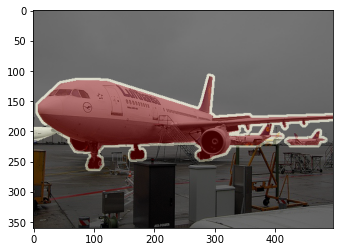

In [157]:
preview(image,onehot2image(mask), 0.5)
#mask = onehot2mask(mask)
#print(mask.shape)

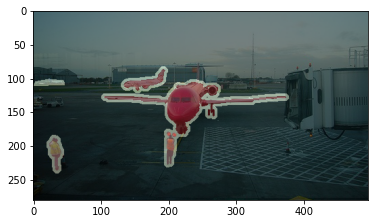

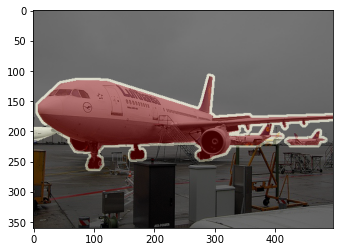

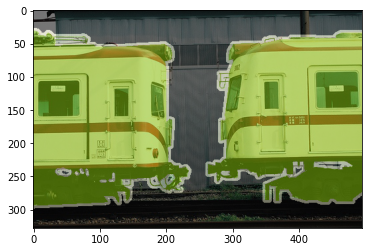

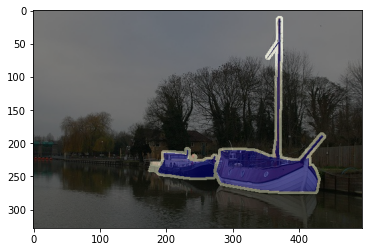

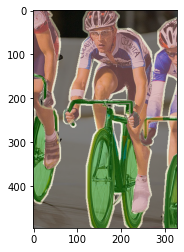

In [158]:
for i in range(5):
    image, mask = train_set[i]
    preview(image, onehot2image(mask), 0.5)

In [95]:
# get an image, mask pair
image, mask = train_set[0]

print(type(image), image.size())
print(type(mask), mask.size)

# get mask palette
palette = mask.getpalette()

# create onehot from mask
onehot = mask2onehot(np.asarray(mask))
print(type(onehot), onehot.shape)

# create mask from onehot
back = onehot2mask(onehot)
print(type(back), back.shape)

# check if the same
print((back==mask).all())

# Create PIL image from array
mask_1 = Image.fromarray(back, 'P') # palette mode
mask_1.putpalette(palette) # set the palette
print(type(mask_1), mask_1.size)

# preview image before and after
preview(image,mask, 0.5)
preview(image,mask_1, 0.5)

<class 'torch.Tensor'> torch.Size([3, 280, 496])
<class 'numpy.ndarray'> 3055360


AttributeError: 'numpy.ndarray' object has no attribute 'getpalette'

In [23]:
# def create_pascal_label_colormap():
#   """Creates a label colormap used in PASCAL VOC segmentation benchmark.

#   Returns:
#     A Colormap for visualizing segmentation results.
#   """
#   colormap = np.zeros((256, 3), dtype=int)
#   ind = np.arange(256, dtype=int)

#   for shift in reversed(range(8)):
#     for channel in range(3):
#       colormap[:, channel] |= ((ind >> channel) & 1) << shift
#     ind >>= 3

#   return colormap.flatten().tolist()
# palette = create_pascal_label_colormap()

In [24]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

In [134]:
# Get a batch of training data
images, masks = next(iter(dataloaders['train']))
print(images.shape, masks.shape)
image, mask = torch.squeeze(images), torch.squeeze(masks)
print(image.shape, mask.shape)

torch.Size([1, 3, 496, 328]) torch.Size([1, 22, 496, 328])
torch.Size([3, 496, 328]) torch.Size([22, 496, 328])


In [135]:
print(image.shape, mask.shape)
for x in [image.numpy(), mask.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

torch.Size([3, 496, 328]) torch.Size([22, 496, 328])
0.0 1.0 0.3183867 0.18466881
0 1 0.045454545454545456 0.2082988952252663


In [136]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = pytorch_unet.UNet(22)
model = model.to(device)

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [137]:
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))

In [143]:
def train_model(model, optimizer, scheduler, num_epochs=1):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device,dtype=torch.float32)
                labels = labels.to(device,dtype=torch.float32)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [159]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 22

model = pytorch_unet.UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

cpu


In [160]:
%%time
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=2)

  0%|          | 0/27 [00:00<?, ?it/s]Epoch 0/1
----------
LR 0.0001
  0%|          | 0/27 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'to'

(3, 6, 192, 192)


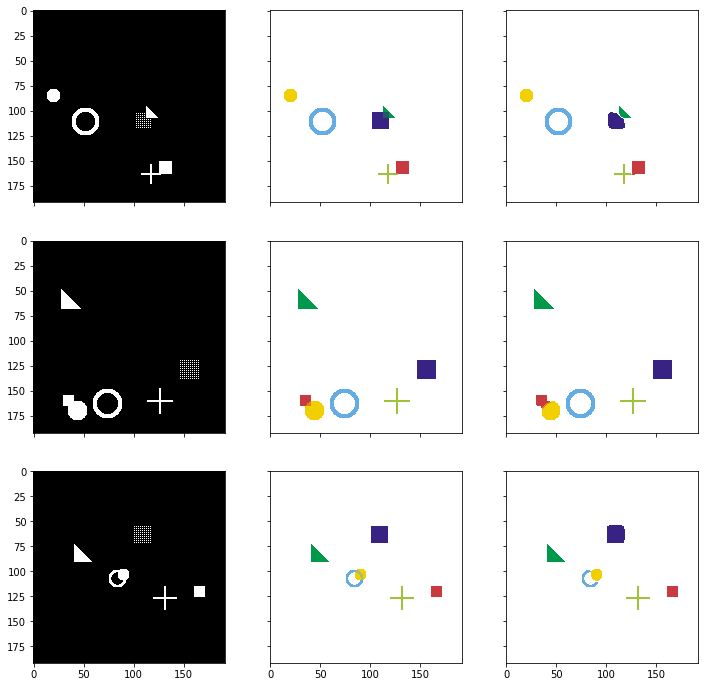

In [8]:
# prediction
model.eval()   # Set model to evaluate mode

test_dataset = SimDataset(3, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])